In [1]:
import yaml
import os
import networkx as nx
from itertools import product
from pprint import pprint
from IPython.display import Image
from IPython.display import display
import pygraphviz
from itertools import permutations

config_path = "../"
figgpath = "../fig/"
fname = os.path.join(config_path, "./conf/wos.yaml")
with open(fname, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [2]:
fillcolor_palette = {
    "violet": "#DDD0E5",
    "green": "#BEDFC8",
    "blue": "#B7D1DF",
    "red": "#EBA59E",
    "orangish": "#FFEFBC"
}

map_type2shape = {
    "table": "box",
    "vcollection": "ellipse",
    "index": "polygon",
    "def_field": "trapezium",
    "field": "octagon",
    "map": "parallelogram"
}
map_type2color = {
    "table": fillcolor_palette["blue"],
    "vcollection": fillcolor_palette["green"],
    "index": "orange",
    "def_field": fillcolor_palette["red"],
    "field": fillcolor_palette["violet"],
    "map": fillcolor_palette["orangish"]
}

edge_status = {"vcollection": "solid", "table": "solid", "map": "solid"}

In [3]:
pprint(config["table"])

[{'filetype': 'publications',
  'vertex_collections': [{'map_fields': {'pubday': 'day',
                                         'pubmonth': 'month',
                                         'pubyear': 'year',
                                         'wos_id': '_key'},
                          'type': 'publication'},
                         {'map_fields': {'source': 'title'}, 'type': 'medium'},
                         {'type': 'language'}]},
 {'filetype': 'contributors',
  'vertex_collections': [{'type': 'contributor'},
                         {'map_fields': {'wos_id': '_key'},
                          'type': 'publication'}]},
 {'filetype': 'institutions',
  'vertex_collections': [{'type': 'organization'},
                         {'map_fields': {'wos_id': '_key'},
                          'type': 'publication'}]},
 {'filetype': 'refs',
  'vertex_collections': [{'map_fields': {'wos_id': '_key'},
                          'type': 'publication'},
                         {'map_fie

In [4]:
g = nx.Graph()

In [5]:
def hashit(x):
    return hash("".join(sorted(x)))

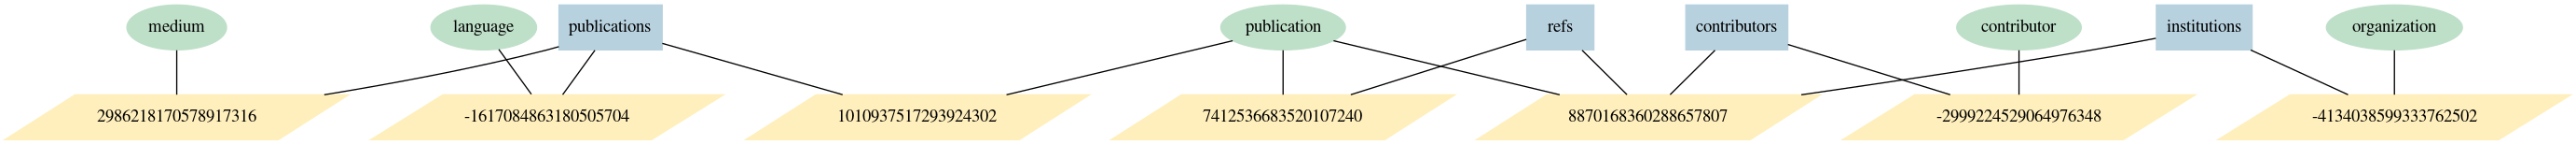

In [6]:
nodes = []
edges = []
for n in config["table"]:
    k = n["filetype"]
    nodes_table = [(k, {"type": "table"})]
    nodes_collection = [
        (item["type"], {"type": "vcollection"}) for item in n["vertex_collections"]
    ]
    nodes_map = [
        (hashit(item["map_fields"].keys()) if "map_fields" in item 
         else hashit(config["vertex_collections"][item["type"]]["index"])
         , {"type": "map"}) for item in n["vertex_collections"]
    ]

    nodes += nodes_table
    nodes += nodes_collection
    nodes += nodes_map
    edges += [(nt[0], nm[0]) for nt, nm in product(nodes_table, nodes_map)]
    edges += [(nm[0], nc[0]) for nm, nc in zip(nodes_map, nodes_collection)]

g.add_nodes_from(nodes)
g.add_edges_from(edges)

for n in g.nodes():
    props = g.nodes()[n]
    upd_dict = {
        "shape": map_type2shape[props["type"]],
        "color": map_type2color[props["type"]],
        "style": "filled",
    }
    for k, v in upd_dict.items():
        g.nodes[n][k] = v

for e in g.edges(data=True):
    s, t, _ = e
    target_props = g.nodes[s]
    upd_dict = {"style": edge_status[target_props["type"]], "arrowhead": "vee"}
    for k, v in upd_dict.items():
        g.edges[s, t][k] = v

ag = nx.nx_agraph.to_agraph(g)
level_one = [n[0] for n in g.nodes(data=True) if n[1]["type"] == "table"]
sg_one = ag.add_subgraph(level_one, rank='same')
level_two = [n[0] for n in g.nodes(data=True) if n[1]["type"] == "vcollection"]
sg_two = ag.add_subgraph(level_two, rank='same')
level_three = [n[0] for n in g.nodes(data=True) if n[1]["type"] == "map"]
sg_three = ag.add_subgraph(level_three, rank='same')
Image(ag.draw(format='png', prog="dot"))

In [7]:
cnodes = [n[0] for n in g.nodes(data=True) if n[1]["type"] == "vcollection"]

In [8]:
acc = []
# generate paths of length 4:
for c in cnodes:
    for n0 in g.neighbors(c):
        for n1 in g.neighbors(n0):
            if g.nodes[n1]["type"] == "table":
                for n2 in g.neighbors(n1):
                    if n2 != n0:
                        for n3 in g.neighbors(n2):
                            if g.nodes[n3]["type"] == "vcollection":
                                item = (c, n0, n1, n2, n3)
#                                 if not item[::-1] in acc:
                                acc += [item]

In [13]:
acc = []
for n in config["table"]:
    for pa, pb in permutations(n["vertex_collections"], 2):
        pa_map = pa["map_fields"] if "map_fields" in pa else {}
        pb_map = pb["map_fields"] if "map_fields" in pb else {}
        item = (pa["type"], pb["type"], pa_map, pb_map, n["filetype"])
        acc += [item]
    
# (vcol_a, vcol_b, map_table_vcol_a, map_table_vcol_b, table) 

In [14]:
acc2 = []
requested_edge_collections = config["edge_collections"].copy()
for item in acc:
    a, b, _, _, _ = item
    if [a, b] in requested_edge_collections:
        acc2 += [item]
        requested_edge_collections.remove([a, b])
        
# config["edge_collections"]

In [15]:
acc2

[('publication',
  'medium',
  {'wos_id': '_key', 'pubyear': 'year', 'pubmonth': 'month', 'pubday': 'day'},
  {'source': 'title'},
  'publications'),
 ('publication',
  'language',
  {'wos_id': '_key', 'pubyear': 'year', 'pubmonth': 'month', 'pubday': 'day'},
  {},
  'publications'),
 ('contributor', 'publication', {}, {'wos_id': '_key'}, 'contributors'),
 ('organization', 'publication', {}, {'wos_id': '_key'}, 'institutions'),
 ('publication', 'publication', {'wos_id': '_key'}, {'uid': '_key'}, 'refs')]